# Importing Dependencies 

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

# Defining the path 

In [2]:
image_dir = Path('./dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Creating a pandas DataFrame 

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(10)

,Filepath,Label
0,dataset\dataset\severe\10017_left - Copy.jpeg,severe
1,dataset\dataset\moderate\IM004347.JPG,moderate
2,dataset\dataset\no_DR\20060529_56420_0100_PP.png,no_DR
3,dataset\dataset\severe\10904_right.jpeg,severe
4,dataset\dataset\severe\9311_right.jpeg,severe
5,dataset\dataset\no_DR\20051201_38246_0400_PP.png,no_DR
6,dataset\dataset\no_DR\20051117_37185_0400_PP.png,no_DR
7,dataset\dataset\proliferate\25823_left.jpeg,proliferate
8,dataset\dataset\severe\22568_right - Copy.jpeg,severe
9,dataset\dataset\severe\3088_left - Copy.jpeg,severe


# Visualize the Images 

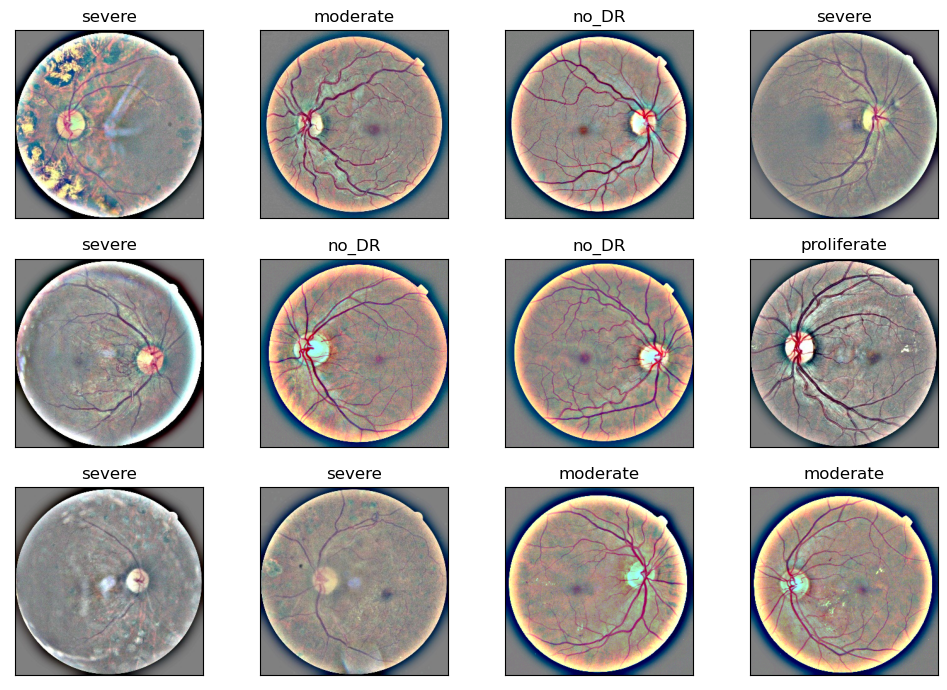

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

# Pie plot to know the distribution of the Images 

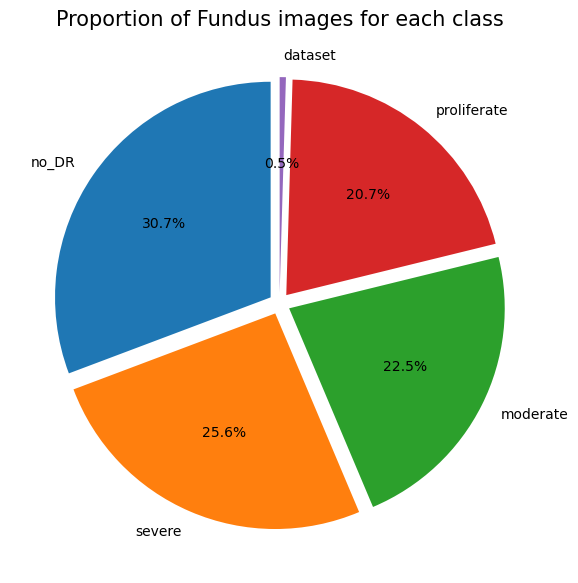

In [5]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(vc.values, labels=vc.index, autopct='%1.1f%%', startangle=90, explode=[0.05]*len(vc))
plt.title("Proportion of Fundus images for each class", fontsize=15)
plt.show()


# Data Augmentation 

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )


    train_images = train_generator.flow_from_dataframe(
        dataframe=image_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=image_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

 
    
    return train_generator,train_images,val_images

# Creating a model

In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
train_generator,train_images,val_images=create_gen()
print('\n')

Found 858 validated image filenames belonging to 4 classes.
Found 214 validated image filenames belonging to 4 classes.




C:\Users\Mohan krishnan\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 5 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
C:\Users\Mohan krishnan\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 5 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


# Loading the pretrained model 

In [9]:
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

29084464/29084464 [==============================] - 43s 1us/step


In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
OPT    = tf.keras.optimizers.Adam(0.001)
model.compile(
    optimizer=OPT,
    loss='categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Training phase of the model 

In [11]:

history = model.fit(
    train_images,
    validation_data=val_images,
    #batch_size = 32,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12
        )
    ]
)
filepath = 'dia_dense.h5'
model.save(filepath)

Epoch 1/15
27/27 [==============================] - 141s 5s/step - loss: 0.9607 - acc: 0.6107 - val_loss: 0.5159 - val_acc: 0.8318
Epoch 2/15
27/27 [==============================] - 152s 6s/step - loss: 0.3948 - acc: 0.8485 - val_loss: 0.3384 - val_acc: 0.8832
Epoch 3/15
27/27 [==============================] - 182s 7s/step - loss: 0.2915 - acc: 0.8928 - val_loss: 0.2727 - val_acc: 0.9019
Epoch 4/15
27/27 [==============================] - 187s 7s/step - loss: 0.2476 - acc: 0.9056 - val_loss: 0.3066 - val_acc: 0.8785
Epoch 5/15
27/27 [==============================] - 202s 8s/step - loss: 0.1889 - acc: 0.9266 - val_loss: 0.2912 - val_acc: 0.8879
Epoch 6/15
27/27 [==============================] - 189s 7s/step - loss: 0.1709 - acc: 0.9464 - val_loss: 0.2356 - val_acc: 0.9019
Epoch 7/15
27/27 [==============================] - 193s 7s/step - loss: 0.1657 - acc: 0.9347 - val_loss: 0.2224 - val_acc: 0.9112
Epoch 8/15
27/27 [==============================] - 188s 7s/step - loss: 0.1406 - a

# Plotting the Accuracy and Loss 

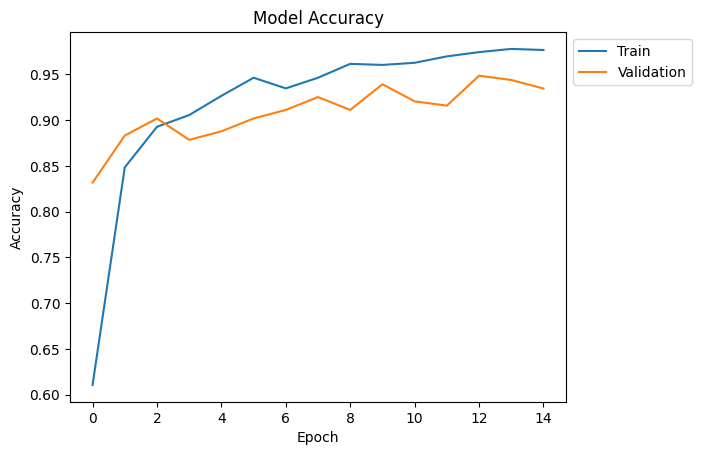

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

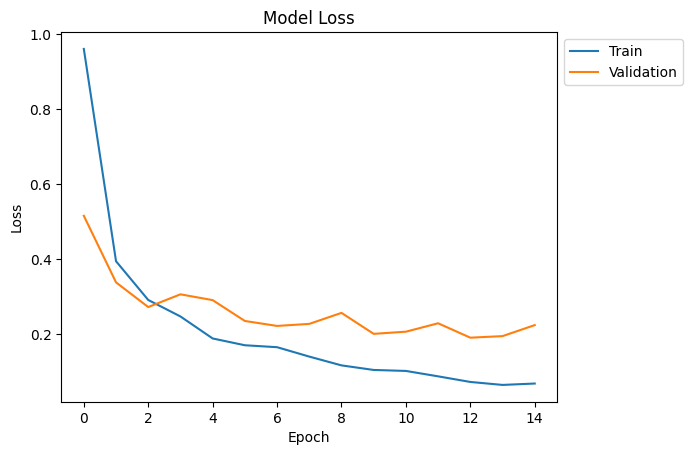

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Saving the model weights 

model.save("dia_dense.h5")
model.summary()

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from  tensorflow.keras.layers import *
from  tensorflow.keras.models import *
from  tensorflow.keras.preprocessing import image
model=load_model('dia_dense.h5')

# Driver code to test the model 

In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

def predict(impath):
    model = load_model('dia_dense.h5')
    classes = ['Moderate diabetic_retinopathy', 'No diabetic_retinopathy', 'Proliferate diabetic_retinopathy', 'Severe diabetic_retinopathy']
    risks = ['Low', 'Moderate', 'High', 'Very High']
    colors = ['\033[92m', '\033[93m', '\033[91m', '\033[91m']

    img = cv2.imread(impath)
    img = cv2.resize(img,(224,224))
    img = img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)
    class_idx = np.argmax(prediction[0])
    class_name = classes[class_idx]
    risk_level = risks[class_idx]
    risk_color = colors[class_idx]

    print(f'Predicted Class: {class_name}')
    print(f'The risk level of developing Proliferate diabetic retinopathy is: {risk_color}{risk_level}\033[0m')

    # Show the image
    plt.imshow(cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Ask the user for feedback
    feedback = input("Did this prediction help you? (yes/no): ")
    if feedback.lower() == 'yes':
        print("I'm glad that I could help!")
    elif feedback.lower() == 'no':
        print("I'm sorry that I couldn't help. Please consult a doctor for further advice.")
    else:
        print("Sorry, I couldn't understand your response. Please try again with 'yes' or 'no'.")




1/1 [==============================] - 2s 2s/step
Predicted Class: Moderate diabetic_retinopathy
The risk level of developing Proliferate diabetic retinopathy is: Low


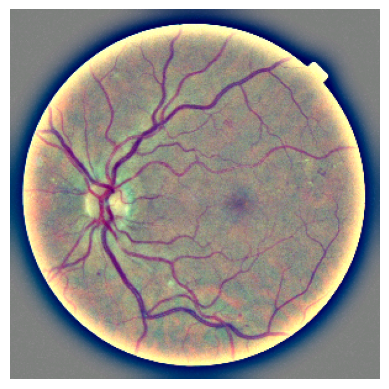

Did this prediction help you? (yes/no): yes
I'm glad that I could help!


In [13]:
predict('Dataset/dataset/moderate/20051020_44349_0100_PP.png')

1/1 [==============================] - 2s 2s/step
Predicted Class: Proliferate diabetic_retinopathy
The risk level of developing Proliferate diabetic retinopathy is: High


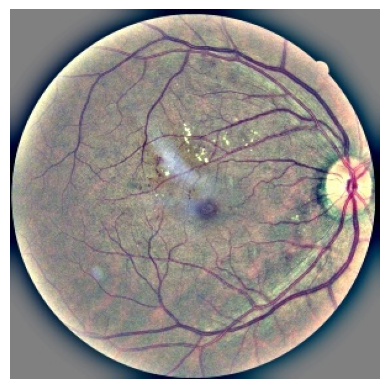

Did this prediction help you? (yes/no): yes
I'm glad that I could help!


In [14]:
predict('Dataset/dataset/proliferate/11031_right.jpeg')